In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import sklearn

## Load Data

In [2]:
# load data
DATASET_DIR = os.path.join("datasets", "housing")
df = pd.read_csv(os.path.join(DATASET_DIR, "housing.csv"))
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [4]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [5]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


## Plotting Data

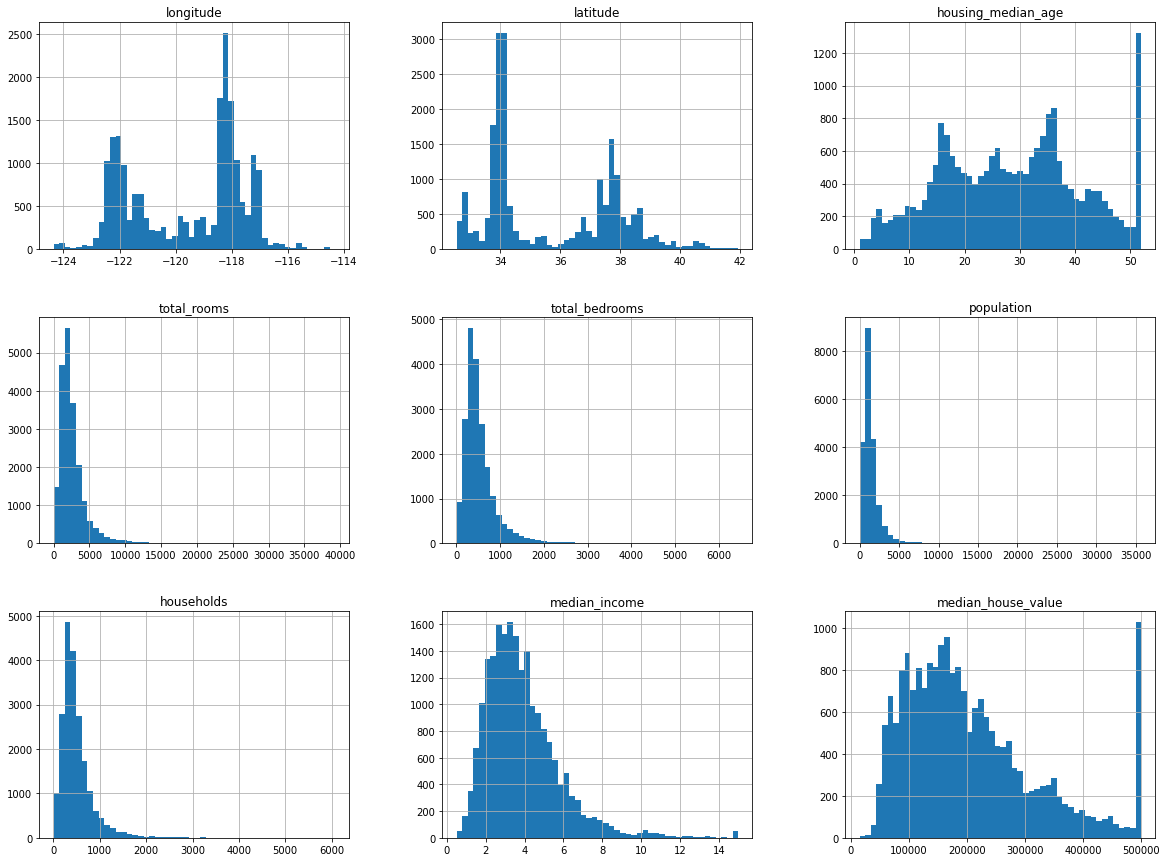

In [6]:
%matplotlib inline
df.hist(bins=50, figsize=(20,15))
matplotlib.pyplot.show()

## Creating a Test Set
Test Set is use for unbiased evaluation of final model fit on a training dataset. we separate about 20% of dataset randomly.

In [7]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
train_set, test_set = split_train_test(df, 0.2)

Problem with above is it will produce different test indices on every run which is what we don't want.
We could use seed to create for generating random indices using `np.random.seed(73)` but it will break when dataset will be updated.
We could associate an unique and immutable identifier with each instance.
If the hash is less than or equal to 20% of max hash value than include it in test set. This will ensure that 20% of new instances and not contain any instance that were previously used in training set.

In [8]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
    # &ing with 0xffffffff ensures that the resulting number is 32 bit unsigned
    # number.
    # if resulting number is less than the test_ratio of 32 bit integer max value
    # then return true
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [9]:
housing_with_id = df.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

If we use row index as the index then we need to make sure that new data gets appended to the end of list and no row gets deleted otherwise row number would change. IF this is not possible then we can use another feature which is not affected by these and stays unique. like we can create new index id = 1000*longitute + latitude

In [10]:
# Sklearn provides methods for splitting dataset into various sets
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

## Stratified Sampling
when taking data randomly from a small dataset we need to make sure that test set is representative of all types of data. otherwise purely random data may be biased.
So to do that we distribute data into different homogeneous groups and then choose from it

<AxesSubplot:>

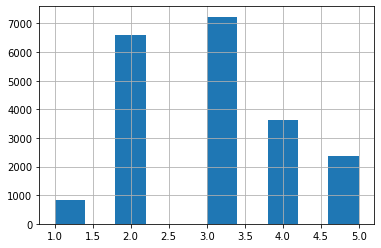

In [17]:
df["income_cat"] = pd.cut(df["median_income"],
                         bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                         labels=[1,2,3,4,5])
df["income_cat"].hist()

In [ ]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3
...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2


In [25]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["income_cat"]):
    strat_train_set = df.loc[train_index]
    strat_test_set = df.loc[test_index]

In [28]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

In [31]:
df["income_cat"].value_counts() / len(df)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

Now we can drop the `income_cat` column

In [33]:
strat_train_set.drop("income_cat", axis=1, inplace=True)
strat_test_set.drop("income_cat", axis=1, inplace=True)

## Visualizing Data


In [46]:
%matplotlib inline
# now we only need to manipulate training set
housing = strat_train_set.copy()
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN
...,...,...,...,...,...,...,...,...,...,...
15174,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900,268500.0,<1H OCEAN
12661,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139,90400.0,INLAND
19263,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797,140400.0,<1H OCEAN
19140,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964,258100.0,<1H OCEAN


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

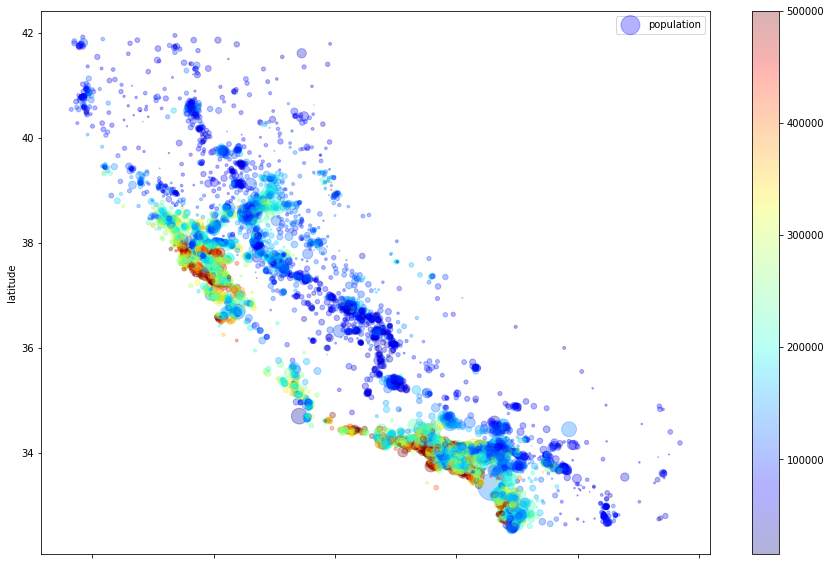

In [66]:
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    label="population",
    s=housing["population"] / 50,
    c=housing["median_house_value"],
    cmap="jet",
    alpha=0.3,
    figsize=(15,10),
    colorbar=True
)

In [70]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

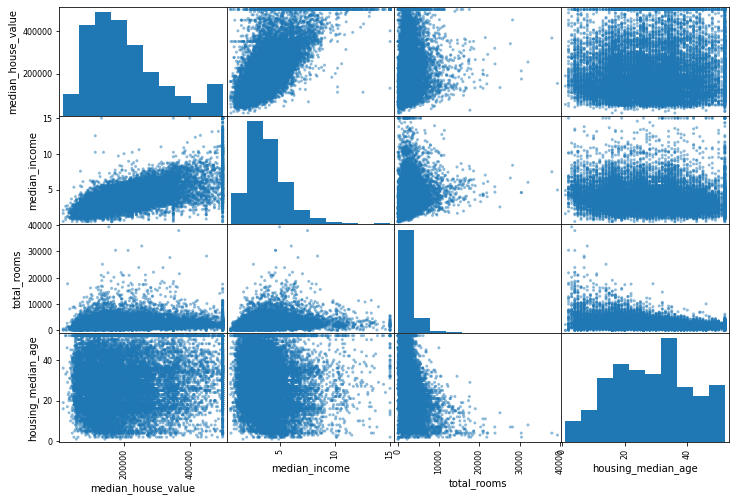

In [76]:
from pandas.plotting import scatter_matrix
attributes= ["median_house_value", "median_income", "total_rooms",
             "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12, 8))

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

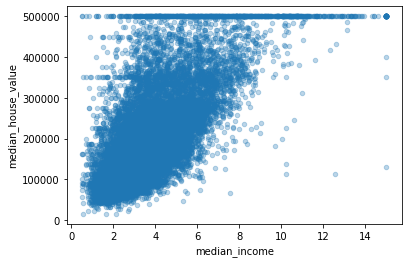

In [80]:
# median_income looks promising attribute to predict median house
housing.plot(kind="scatter", y="median_house_value", x="median_income", alpha=0.3)

In [82]:
# Adding some useful features
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

In [83]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

## Preparing Data for Machine Learning Algorithms
We should write functions to prepare data instead of doing it manually.
There are several good reasons:
1. This will allow you to reproduce these transformations on any dataset.
2. We will gradually build a library of transformation functions which can be used later.
3. We can use these function in your live systems to transform the new data before feeding it to your algorithm
4. This will make it possible for you to easily try various transformations and see which combination of transformations works best.

In [86]:
# Separating labels and predictors
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data cleaning

In [87]:
# Taking care of missing values
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

In [90]:
# To take care of missing values Scikit_learn provides SimpleImptuer class.
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [93]:
housing_num = housing.drop("ocean_proximity", axis=1)
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [94]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [99]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [100]:
X = imputer.transform(housing_num)

In [102]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736
1,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373
2,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750
3,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264
4,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964
...,...,...,...,...,...,...,...,...
16507,-117.07,33.03,14.0,6665.0,1231.0,2026.0,1001.0,5.0900
16508,-121.42,38.51,15.0,7901.0,1422.0,4769.0,1418.0,2.8139
16509,-122.72,38.44,48.0,707.0,166.0,458.0,172.0,3.1797
16510,-122.70,38.31,14.0,3155.0,580.0,1208.0,501.0,4.1964


In [104]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [108]:
# ML algos work with numbers so let's convert these categories from text to numbers.
# Scikit_learns OrdinalEncoder class provides support for this
from sklearn.preprocessing import OrdinalEncoder
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [109]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [110]:
# ML algos may assume two nearby values are more similar than two distant values.
# which is true in some cases (e.g. worse, bad, good, better)
# but not in our case
# so, We can create one binary attribute per category known as One Hot Encoding.
# only one attribute will be hot (1) and others will be cold(0)
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [111]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [112]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### creating custom transformers

In [118]:
"""
Scikit-Learn relies on duck typing.
So, our class should implement three methods: fit(), transform(), fit_transform()
TransformerMixin base class provides -> fit_transform()
BaseEstimator base class provides -> get_params(), set_params(). used
for automatic hypertuning
"""

from sklearn.base import BaseEstimator, TransformerMixin
room_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):# hyperparameter
        # make those attribs hyperparameter which are you not sure about
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, room_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, room_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Feature Scaling
to make the scale of different attributes same.
- two common ways: 
    - min-max scaling(normalization) and 
        - subtract min value and then dividing by max - min
        - ranges [0, 1]
        - Sklearn's `MinMaxScaler`
    - standardization
        - subtract mean from all values so that mean becomes zero
        - and divide by standard deviation so that resulting distribution has unit variance.
        - not good for NNs but are less affected by outliers.
        - no specific range
        - Sklearn's `StandardScaler`

## Transformation Pipelines
There are many data transformation steps that need to be executed in the right order. Scikit-Learn provides the Pipeline class to help with such sequences of transformations.

In [119]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])
# Pipeline constructor takes name, estimators pair
# last estimator must be transformer(i.e. they must have fit_transform method)
# calls fit_transform() sequentially on all transformers until last where it calls
# fit() method.
# pipeline exposes same methods as final estimator.
# in this case last estimator is transformer so pipeline will have transform() method
# and also fit_trasnform()
housing_num_tr = num_pipeline.fit_transform(housing_num)

In [120]:
# So far we handled categorical columns and numerical columns separately.
# it would be more convinient to have a single transformer able to handle all columns

In [127]:
from sklearn.compose import ColumnTransformer
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs)
])
housing_prepared = full_pipeline.fit_transform(housing)

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

## Select and Train a Model

In [129]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [134]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))
print("Labels:", list(some_labels))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]
Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


In [138]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745